# Group Project: Machine Learning 

- <a href='#part1'>Part 1: Deep L-Layer Neural Network for Image Classification</a>
	- You will use pre-built functions to build an L-Layer neural network for an image classification task
- <a href='#part2'>Part 2: Full Machine Learning Project</a>
	- You will go through the full "idea, code, experiment" cycle to build and improve a model of your choice

You may work in groups of 1-3 students for this project.

In this project, especially in Part 2, you are expected to show the work you have done in the form of including results for models you have experimented with on the path to the best-performing model. Make sure you include Python and markdown boxes explaining and discussing any decisions you have made and interpretations of the results you have achieved. You can include diagrams, tables, and/or graphs using markdown. **A significant portion of your grade will be based on the progression of your model, not just the final result.**

**Note**: All work you submit must be the work of your group. Projects will be checked against each other, and against any work submitted in previous semesters where a similar project was given.

<a id="part1"></a>
## Part 1: Deep L-Layer Neural Network for Image Classification

You will use the functions given to you to build a deep L-layer network, and apply it to cat vs non-cat classification. Hopefully, you will see an improvement in accuracy relative to your previous logistic regression implementation.  

### 1.1 - Packages

Let's first import all the packages that you will need during this assignment. 
- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [PIL](https://pillow.readthedocs.io/en/stable/index.html) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.
- nn_functions provides the functions you need to build an L-layer network.
- np.random.seed(1) is used to keep all the random function calls consistent. It will help us grade your work.

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from nn_functions import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

### 1.2 - Dataset

You will use the same "Cat vs non-Cat" dataset as in your previous assignment. The model you had built had 70% test accuracy on classifying cats vs non-cats images. Hopefully, your new model will perform a better!

**Problem Statement**: You are given a dataset containing:
- a training set of m_train images labelled as cat (1) or non-cat (0)
- a test set of m_test images labelled as cat and non-cat
- each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).

Let's get more familiar with the dataset. Load the data by running the cell below.

In [2]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images. 

y = 1. It's a cat picture.


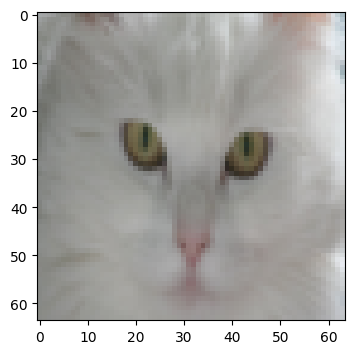

In [3]:
# Example of a picture
index = 50
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [4]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


As usual, you reshape and standardize the images before feeding them to the network. The code is given in the cell below.

<img src="images/imvectorkiank.png" style="width:450px;height:300px;">

<caption><center> <u>Figure 1</u>: Image to vector conversion. <br> </center></caption>

In [5]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


$12,288$ equals $64 \times 64 \times 3$ which is the size of one reshaped image vector.

### 1.3 - Architecture of your model

Now that you are familiar with the dataset, it is time to build a deep neural network to distinguish cat images from non-cat images.

Here is a simplified network representation for an L-layer neural network:

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 2</u>: L-layer neural network.</center></caption> 

The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>Detailed Architecture of figure 2</u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, you take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, you take the sigmoid of the final linear unit. If it is greater than 0.5, you classify it to be a cat.

<u>General methodology</u>

As usual you will follow the Deep Learning methodology to build the model:
1. Initialize parameters / Define hyperparameters
2. Loop for num_iterations:
    - Forward propagation
    - Compute cost function
    - Backward propagation
    - Update parameters (using parameters, and grads from backprop) 
4. Use trained parameters to predict labels

### 1.4 - L-layer Neural Network

**Exercise**: Use the helper functions in the nn_functions file to build an $L$-layer neural network with the following structure: **[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID**. Spend some time looking through the functions and understanding how they can be used to build a deep neural network. The functions you may need and their inputs are:
```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [6]:
### CONSTANTS ###
layers_dims = [12288, 19, 7, 5, 1] #  4-layer model

In [7]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)

    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # START CODE HERE ### (≈ 4 lines of code)
        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        # Compute cost.
        cost = compute_cost(AL, Y)
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

You will now train the model as a 4-layer neural network. 

Run the cell below to train your model. The cost should decrease on every iteration. It may take a few minutes to run 2500 iterations. 

Cost after iteration 0: 0.694084
Cost after iteration 100: 0.598126
Cost after iteration 200: 0.531536
Cost after iteration 300: 0.497365
Cost after iteration 400: 0.445215
Cost after iteration 500: 0.393239
Cost after iteration 600: 0.322528
Cost after iteration 700: 0.240461
Cost after iteration 800: 0.123348
Cost after iteration 900: 0.078480
Cost after iteration 1000: 0.047948
Cost after iteration 1100: 0.033076
Cost after iteration 1200: 0.024765
Cost after iteration 1300: 0.019542
Cost after iteration 1400: 0.016046
Cost after iteration 1500: 0.013532
Cost after iteration 1600: 0.011640
Cost after iteration 1700: 0.010277
Cost after iteration 1800: 0.007524
Cost after iteration 1900: 0.005619
Cost after iteration 2000: 0.004801
Cost after iteration 2100: 0.004213
Cost after iteration 2200: 0.003749
Cost after iteration 2300: 0.003371
Cost after iteration 2400: 0.003058
Cost after iteration 2500: 0.002793
Cost after iteration 2600: 0.002566
Cost after iteration 2700: 0.002369
Cost

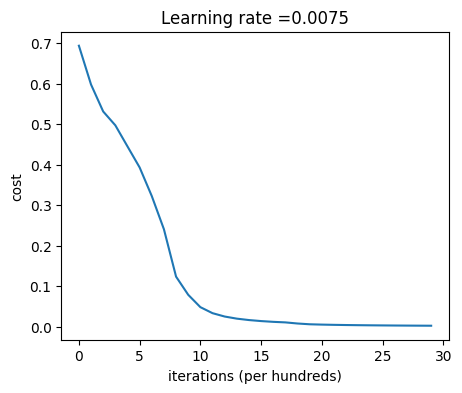

In [8]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 3000, print_cost = True)

In [9]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [10]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.7200000000000001


Congratulations! It seems that your 4-layer neural network has better performance than your previous assignment network on the same test set. 

This is good performance for this task.

###  1.5 - Results Analysis

First, let's take a look at some images the L-layer model labeled incorrectly. This will show a few mislabeled images. 

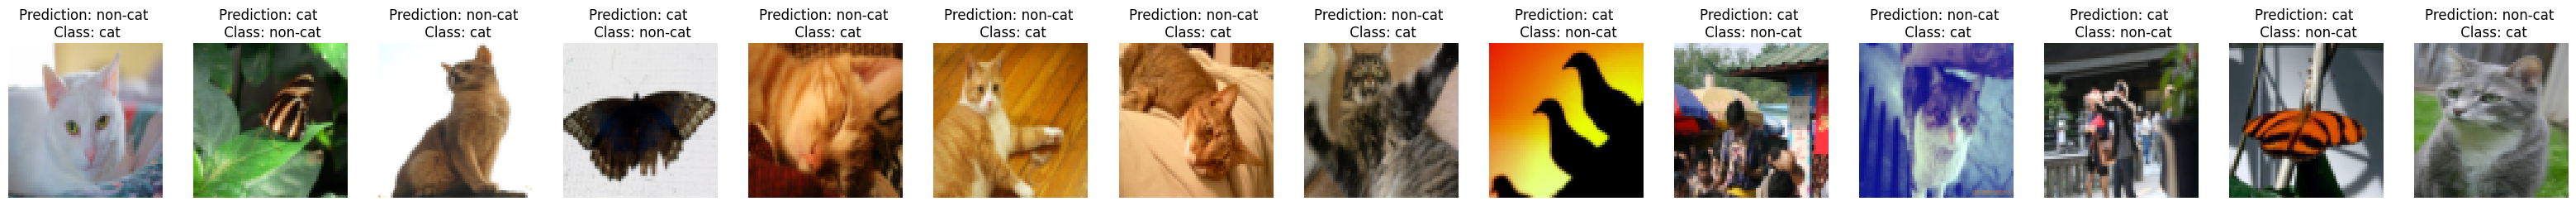

In [11]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**A few types of images the model tends to do poorly on include:** 
- Cat body in an unusual position
- Cat appears against a background of a similar color
- Unusual cat color and species
- Camera Angle
- Brightness of the picture
- Scale variation (cat is very large or small in image) 

### 1.6 - Test with your own image (optional/ungraded exercise) ##

You can use your own image and see the output of your model. To do that:
1. Add your image to the "images" folder
2. Change your image's name in the following code
3. Run the code and check if the algorithm is right (1 = cat, 0 = non-cat)!

Accuracy: 1.0
y = 1.0, your L-layer model predicts a "cat" picture.


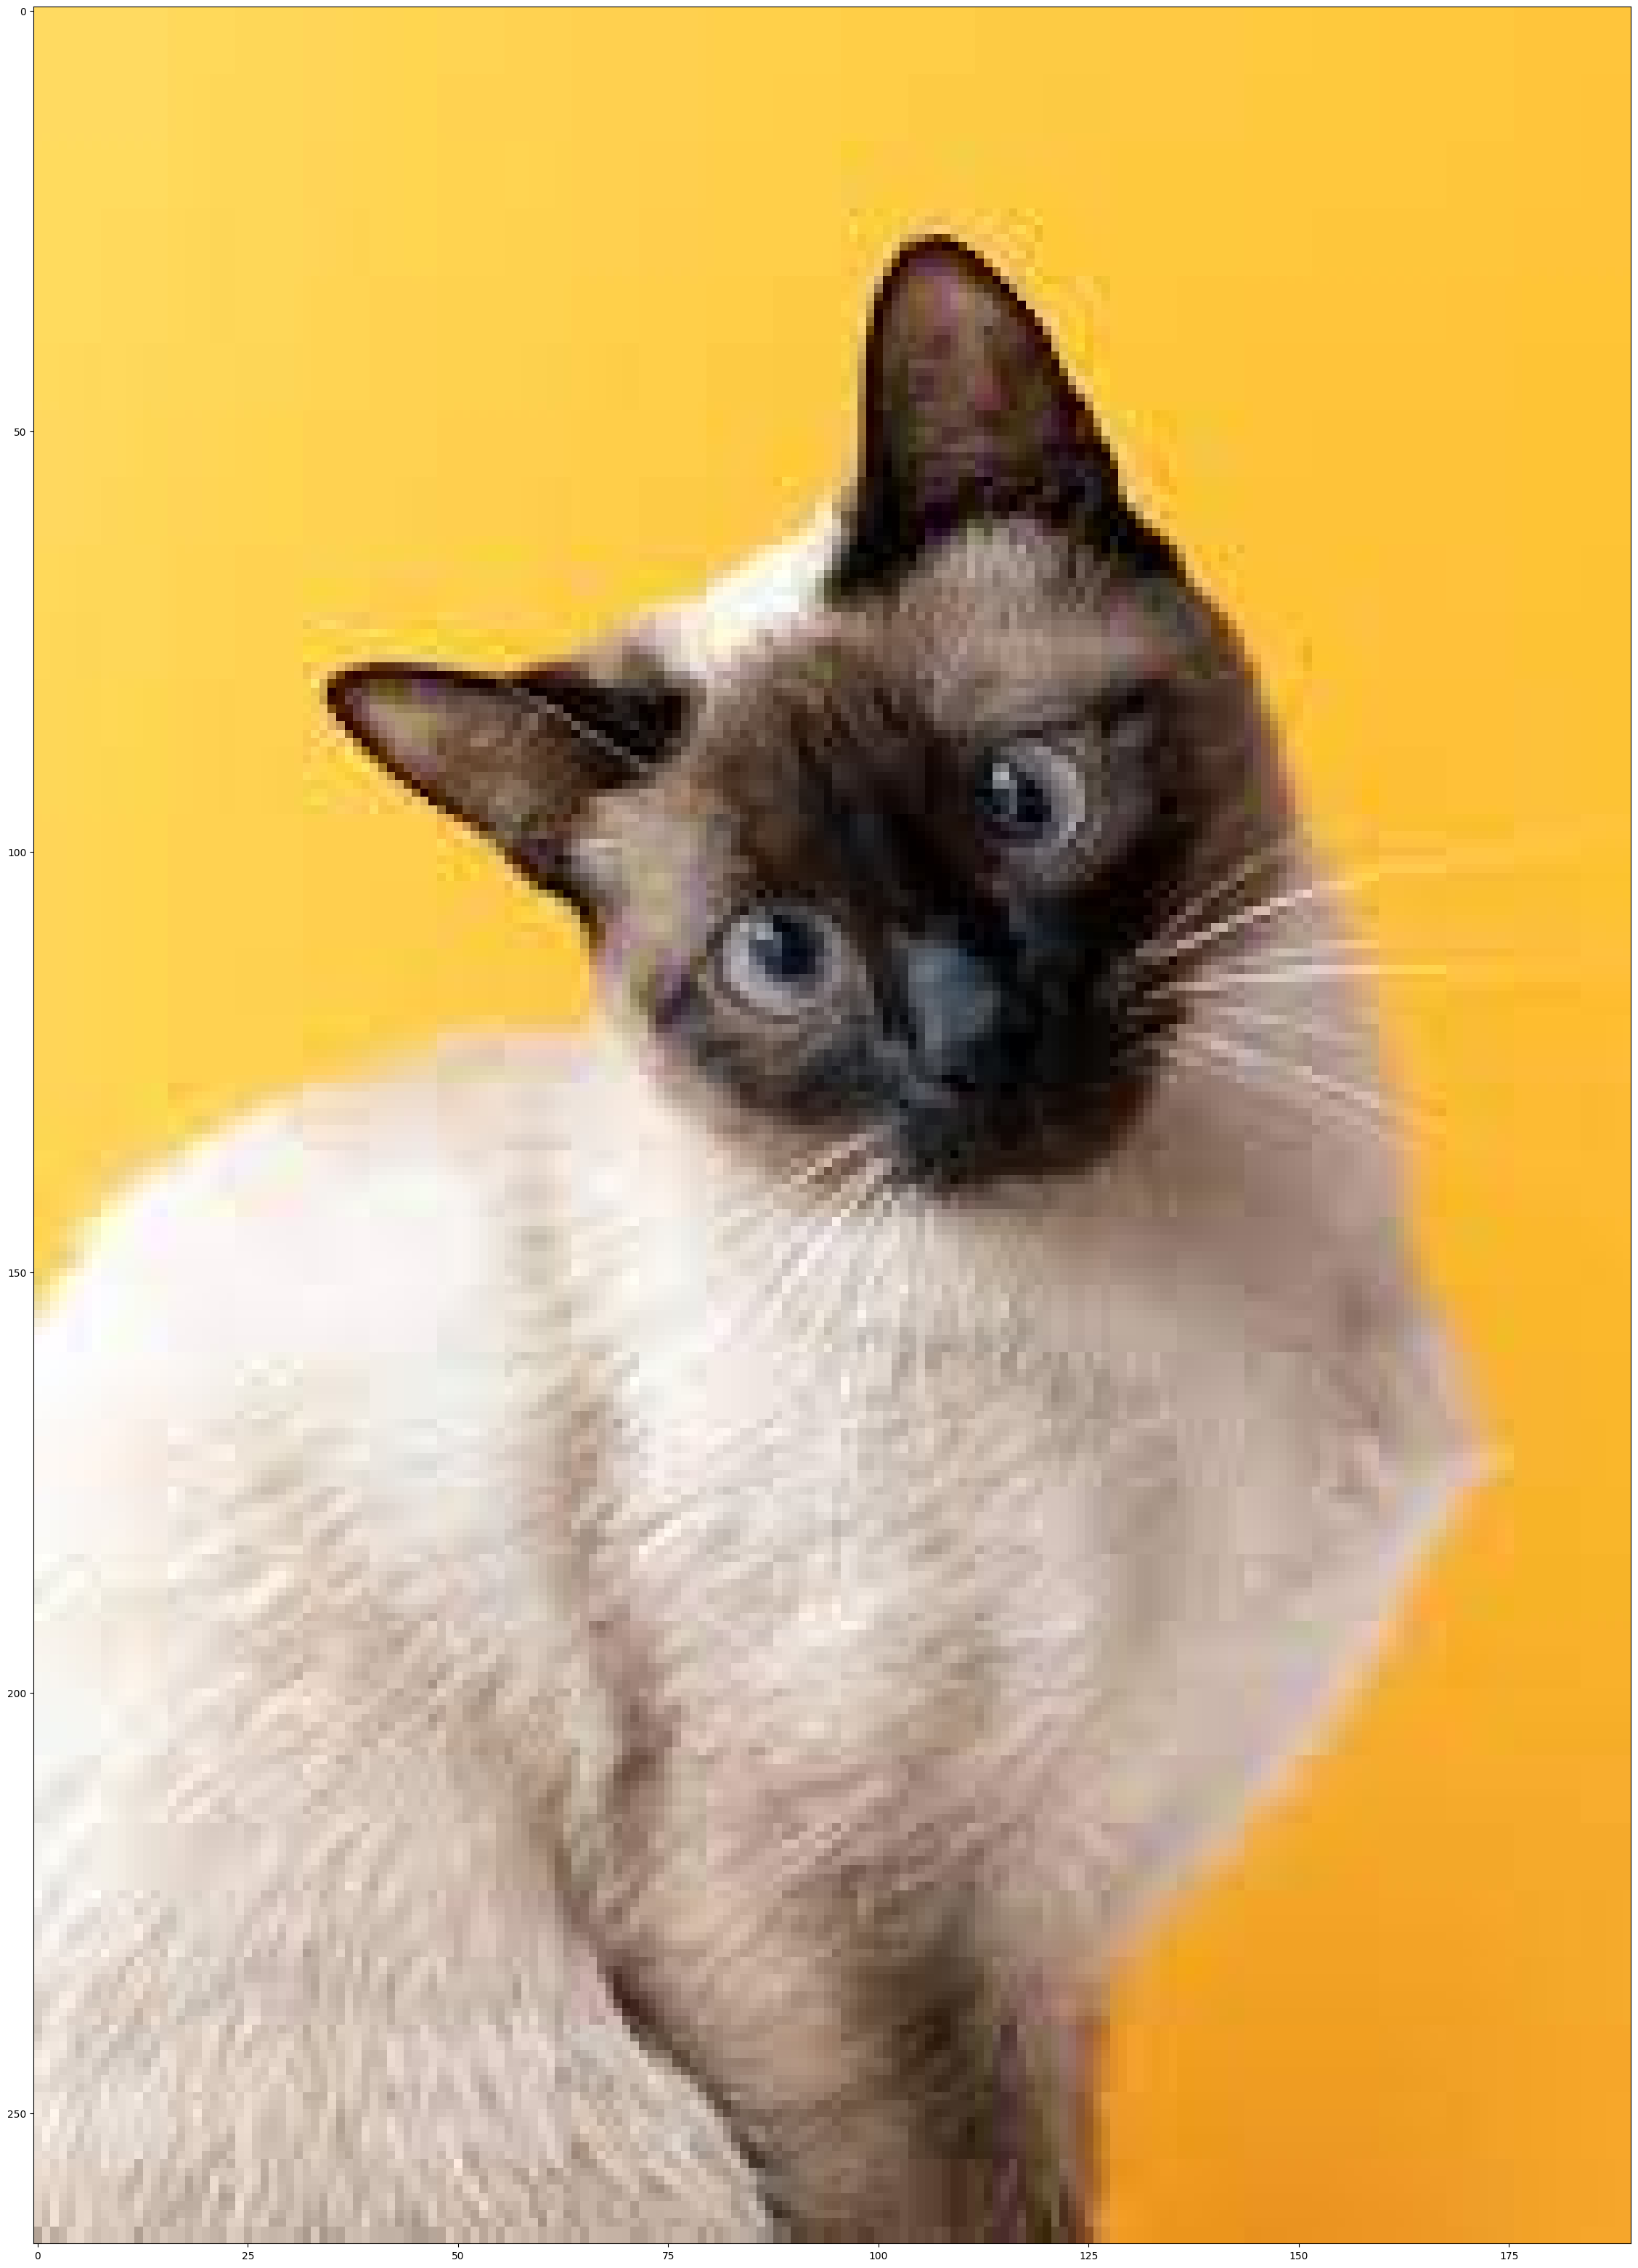

In [12]:
## START CODE HERE ##
my_image = "cat_yellow_bkgrd.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##

fname = "images/" + my_image
image = Image.open(fname)
my_image = np.array(image.resize((num_px, num_px))).reshape((1, num_px*num_px*3)).T
my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

<a id="part2"></a>
## Part 2: Full Machine Learning Project

Now you will use all you know about building and training neural networks in an "idea, code, experiment" cycle on a data set.

### 2.1 - Find a dataset (or datasets)

Find an appropriate dataset to work with. Some places to look:
- [Kaggle](https://www.kaggle.com/datasets) 
- [University of California, Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.php)

You can choose just one, or more than one if you'd like to. Think carefully of the type of task you are trying to accomplish (e.g., classification, regression, etc.). Spend some time analyzing and processing the data. For example, decide how to split the data; should you have separate train, dev, and test sets? Does the data need to be cleaned or adjusted? How should the data be normalized? Any other considerations or adjustments needed for the data?

Clearly indicate where you found the dataset(s) you are working with.

Show the work you have done analyzing and processing the data in Python boxes in this notebook. There should also be associated markdown boxes discussing what you have observed and what decisions you have made.




I am choosing to use a dataset that, given characteristics of a breast cancer diagnosis, returns whether the diagnosis was belign or malignant, the exact attributes are listed below: 
1. Sample code number: id number
2. Clump Thickness: 1 - 10
3. Uniformity of Cell Size: 1 - 10
4. Uniformity of Cell Shape: 1 - 10
5. Marginal Adhesion: 1 - 10
6. Single Epithelial Cell Size: 1 - 10
7. Bare Nuclei: 1 - 10
8. Bland Chromatin: 1 - 10
9. Normal Nucleoli: 1 - 10
10. Mitoses: 1 - 10
11. Class: (2 for benign, 4 for malignant)

There were 16 examples that had missing attributes, and since it was just a few examples, I removed them manually.
This dataset was found on the UCI Machine Learning Repository, at this link: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Original%29

In [13]:
# Your work for analyzing and processing the data
filename = "datasets/breast-cancer-wisconsin.data"
dataset = np.genfromtxt(filename, delimiter=",")
#splitting given data into a training set and testing set
train_set = dataset[:350]
test_set = dataset[350:]

#splitting both sets into input matrix and label matrix, the set[:, 1:-1] removes the id number from the list of parameters since it is irrelevant
train_set_X, train_set_Y = train_set[:, 1:-1], train_set[:, -1]
test_set_X, test_set_Y = test_set[:, 1:-1], test_set[:, -1]
train_set_X, train_set_Y = train_set_X.T, train_set_Y.reshape(1, train_set_Y.shape[0])
test_set_X, test_set_Y = test_set_X.T, test_set_Y.reshape(1, test_set_Y.shape[0])

#label coloumn has entries of 2 and 4, so dividing by 2 and subtracting 1 gives binary values 0 and 1
train_set_Y, test_set_Y = (train_set_Y/2)-1, (test_set_Y/2)-1

print("Training data input shape: ", train_set_X.shape)
print("Training data label shape: ", train_set_Y.shape)
print("Testing data input shape: ", test_set_X.shape)
print("Testing data label shape: ", test_set_Y.shape)

Training data input shape:  (9, 350)
Training data label shape:  (1, 350)
Testing data input shape:  (9, 333)
Testing data label shape:  (1, 333)


### 2.2 - Build your model

Start with a basic model, show the results, and then apply whichever improvements you decide to incorporate as per below.

You have two options for building your model:
- **The difficult option**: Use the provided L-layer network code used above in Part 1 and (later) extend it to incorporate more advanced neural network improvements as given in class
- **The easier option**: Use [Keras](https://keras.io) and [TensorFlow](https://www.tensorflow.org) to build a network
	- You may *not* use any framework other than Keras/TensorFlow

Ambition will be rewarded! If you choose the easier option, you are expected to incorporate more of the potential improvements given below.

Some of the neural network improvements you can consider incorporating for either option (not an exhaustive list):
- Weight initialization methods (e.g., zeroes, random, etc.)
- Regularization: L2, dropout, etc.
- Mini-batch gradient descent
- Gradient descent optimization algorithm: momentum, RMSProp, Adam, etc.
- Batch normalization

Show the results with your model with improvements. Use markdown boxes to discuss the effect of your improvement(s) and change in accuracy.

This is the initial model, using the given network code for the L layer model.

Cost after iteration 0: 0.513706
Cost after iteration 100: 0.438457
Cost after iteration 200: 0.382969
Cost after iteration 300: 0.344121
Cost after iteration 400: 0.317423
Cost after iteration 500: 0.297628
Cost after iteration 600: 0.281199
Cost after iteration 700: 0.266403
Cost after iteration 800: 0.253672
Cost after iteration 900: 0.242557
Cost after iteration 1000: 0.232603
Cost after iteration 1100: 0.223593
Cost after iteration 1200: 0.215245
Cost after iteration 1300: 0.207459
Cost after iteration 1400: 0.200507
Cost after iteration 1500: 0.194192
Cost after iteration 1600: 0.188380
Cost after iteration 1700: 0.183000
Cost after iteration 1800: 0.178017
Cost after iteration 1900: 0.173419
Cost after iteration 2000: 0.169112
Cost after iteration 2100: 0.165053
Cost after iteration 2200: 0.161211
Cost after iteration 2300: 0.157554
Cost after iteration 2400: 0.154072
Cost after iteration 2500: 0.150753
Cost after iteration 2600: 0.147592
Cost after iteration 2700: 0.144569
Cost

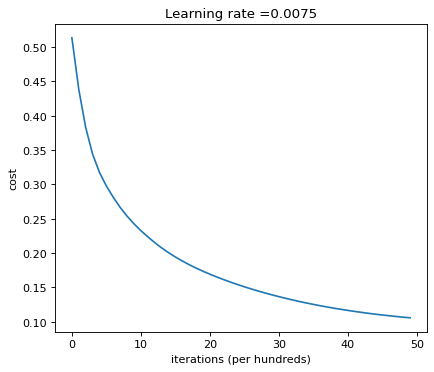

In [14]:
# Your work for building a basic model and then applying improvements
layers_dims = [9, 7, 5, 1]

def my_L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)

    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # START CODE HERE ### (≈ 4 lines of code)
        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        # Compute cost.
        cost = compute_cost(AL, Y)
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.figure(figsize = (6,5), dpi = 80)
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

parameters_basic = my_L_layer_model(train_set_X, train_set_Y, layers_dims, num_iterations = 5000, print_cost = True)

In [15]:
print("Accuracy on training set:")
pred_train_basic = predict(train_set_X, train_set_Y, parameters_basic)
print("Accuracy on test set:")
pred_test_basic = predict(test_set_X, test_set_Y, parameters_basic)

Accuracy on training set:
Accuracy: 0.9657142857142857
Accuracy on test set:
Accuracy: 0.987987987987988


The accuracy is quite good, but the cost after many iterations is still quite large, so I'd like to make some improvements to reduce that. I'll try implementing gradient descent with momentum to see if that improves the cost. 
I define 2 new functions in nn_functions.py: 
- initialize_parameters_momentum(), a slightly modified version of initialize_parameters(), where sDw is initialized as a matrix of zeros instead of random values.
- update_parameters_momentum(), a modified version of update_parameters(), where the average of the gradients is recorded, and gradient descent with momentum is implemented.


Cost after iteration 0: 0.513706
Cost after iteration 100: 0.443912
Cost after iteration 200: 0.386891
Cost after iteration 300: 0.346469
Cost after iteration 400: 0.318879
Cost after iteration 500: 0.298733
Cost after iteration 600: 0.282263
Cost after iteration 700: 0.267329
Cost after iteration 800: 0.254431
Cost after iteration 900: 0.243240
Cost after iteration 1000: 0.233226
Cost after iteration 1100: 0.224172
Cost after iteration 1200: 0.215844
Cost after iteration 1300: 0.208018
Cost after iteration 1400: 0.200999
Cost after iteration 1500: 0.194652
Cost after iteration 1600: 0.188823
Cost after iteration 1700: 0.183428
Cost after iteration 1800: 0.178431
Cost after iteration 1900: 0.173816
Cost after iteration 2000: 0.169503
Cost after iteration 2100: 0.165441
Cost after iteration 2200: 0.161600
Cost after iteration 2300: 0.157945
Cost after iteration 2400: 0.154470
Cost after iteration 2500: 0.151148
Cost after iteration 2600: 0.147985
Cost after iteration 2700: 0.144960
Cost

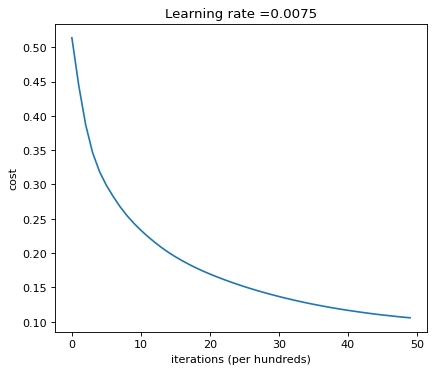

In [16]:
layers_dims = [9, 7, 5, 1]

def my_L_layer_model_momentum(X, Y, layers_dims, beta, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    gradsAvg = initialize_parameters_momentum(layers_dims) #initialize parameters for sDw and sDb
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)

    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # START CODE HERE ### (≈ 4 lines of code)
        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        # Compute cost.
        cost = compute_cost(AL, Y)
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
        # Update parameters.
        parameters = update_parameters_momentum(parameters, grads, learning_rate, gradsAvg, beta)

        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.figure(figsize = (6,5), dpi = 80)
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

parameters_momentum = my_L_layer_model_momentum(train_set_X, train_set_Y, layers_dims, 0.9, num_iterations = 5000, print_cost = True)

In [17]:
print("Accuracy on training set:")
pred_train_momentum = predict(train_set_X, train_set_Y, parameters_momentum)
print("Accuracy on test set:")
pred_test_momentum = predict(test_set_X, test_set_Y, parameters_momentum)

Accuracy on training set:
Accuracy: 0.9657142857142857
Accuracy on test set:
Accuracy: 0.987987987987988


Interestingly, using gradient descent with momentum slightly increased the cost rather than lowering it. This might be because of the value chosen for beta (0.9), but before I adjust this value, I will try to implement RMSprop as well, to see if that changes anything first.
For this, I define 1 extra function called update_parameters_RMSprop(), and I reuse the function for creating parameters from my model using momentum.

Cost after iteration 0: 0.513706
Cost after iteration 100: 0.139457
Cost after iteration 200: 0.097761
Cost after iteration 300: 0.085353
Cost after iteration 400: 0.078663
Cost after iteration 500: 0.071581
Cost after iteration 600: 0.058095
Cost after iteration 700: 0.046877
Cost after iteration 800: 0.039714
Cost after iteration 900: 0.072852
Cost after iteration 1000: nan
Cost after iteration 1100: nan
Cost after iteration 1200: nan
Cost after iteration 1300: nan
Cost after iteration 1400: nan
Cost after iteration 1500: nan


d:\download\code\cmpt 310 finalproject\nn_functions.py:243: RuntimeWarning: divide by zero encountered in log
  cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
d:\download\code\cmpt 310 finalproject\nn_functions.py:328: RuntimeWarning: invalid value encountered in divide
  dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))


Cost after iteration 1600: nan
Cost after iteration 1700: nan
Cost after iteration 1800: nan
Cost after iteration 1900: nan
Cost after iteration 2000: nan
Cost after iteration 2100: nan
Cost after iteration 2200: nan
Cost after iteration 2300: nan
Cost after iteration 2400: nan


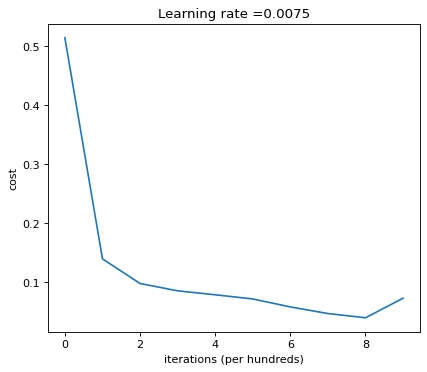

In [18]:
layers_dims = [9, 7, 5, 1]

def my_L_layer_model_RMSprop(X, Y, layers_dims, beta, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    gradsAvg = initialize_parameters_momentum(layers_dims) #initialize parameters for sDw and sDb
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)

    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # START CODE HERE ### (≈ 4 lines of code)
        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        # Compute cost.
        cost = compute_cost(AL, Y)
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
        # Update parameters.
        parameters = update_parameters_RMSprop(parameters, grads, learning_rate, gradsAvg, beta)

        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.figure(figsize = (6,5), dpi = 80)
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

parameters_RMSprop = my_L_layer_model_RMSprop(train_set_X, train_set_Y, layers_dims, 0.9, num_iterations = 2500, print_cost = True)

In [19]:
print("Accuracy on training set:")
pred_train_RMSprop = predict(train_set_X, train_set_Y, parameters_RMSprop)
print("Accuracy on test set:")
pred_test_RMSprop = predict(test_set_X, test_set_Y, parameters_RMSprop)

Accuracy on training set:
Accuracy: 0.5314285714285715
Accuracy on test set:
Accuracy: 0.7747747747747747


In this model, the loss function sharply declined and then became NaN. I did a bit of research into this, and this is likely a case of an exploding gradient problem, an issue in machine learning where when the gradients are large, multiplication of these gradients become huge as the process continues. So even though the loss is low, this model will likely not perform well. A proposed fix to this is to adjust hyperparameters, so using my 2 models, I will move toward the Idea, Code, Experiment Cycle to optimize for the best results.

### 2.3 - Idea, Code, Experiment Cycle

Now go through a iterative process to improve your model. This will involve things like (not an exhaustive list):
- Checking whether you have a bias and/or variance problem. How will you address it? 
- Hyperparameter tuning: learning rate, # of layers, # of hidden units, activation functions, mini-batch size, etc.
- Trying any of the improvements made to the model in part 2.2 to see if it leads to better results

We want to see the progression of your model to a final version with the best results you can achieve. You don't have to show results for every single experiment you tried, but a general progression of different models at various stages of development should be included. Feel free to include discussion, diagrams, tables, and/or graphs that may summarize some of your experiments. **If you only show us the final model you've built, your mark will be minimal**.

Your discussion should also include details on the methodology you used in your experiments. For example, how did you approach hyperparameter tuning?


Given that I have 2 models to work with, gradient descent with momentum and gradient descent using RMSprop, I will adjust hyperparameters for both to see which performs better overall. I will first start with my momentum model.

In [20]:
layers_dims = [9,7,5,1]

In [21]:
def my_L_layer_model_momentum(X, Y, layers_dims, beta, learning_rate = 0.0075, num_iterations = 3000, print_cost=False, plot_cost = False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    gradsAvg = initialize_parameters_momentum(layers_dims) #initialize parameters for sDw and sDb
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)

    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # START CODE HERE ### (≈ 4 lines of code)
        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        # Compute cost.
        cost = compute_cost(AL, Y)
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
        # Update parameters.
        parameters = update_parameters_momentum(parameters, grads, learning_rate, gradsAvg, beta)

        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    if(plot_cost):
        plt.figure(figsize = (6,5), dpi = 80)
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per hundreds)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
    return parameters

The following code experiments with what happens as the values of beta and the learning rate change. Changing both parameters at the same time allows for more values to be checked overall, and once I find a interesting result, I can hone in on that area.

In [22]:
# Your work for experiments
for i in range(5):
    parameters_momentum = my_L_layer_model_momentum(train_set_X, train_set_Y, layers_dims, 0.99-i*0.2, 0.0075+i*0.0005, num_iterations = 2500)
    print("beta =", 0.99-i*0.2, "learning rate =", 0.0075+i*0.0005)
    print("Accuracy on training set:")
    pred_train_momentum = predict(train_set_X, train_set_Y, parameters_momentum)
    print("Accuracy on test set:")
    pred_test_momentum = predict(test_set_X, test_set_Y, parameters_momentum)
    print("")
    

beta = 0.99 learning rate = 0.0075
Accuracy on training set:
Accuracy: 0.96
Accuracy on test set:
Accuracy: 0.96996996996997

beta = 0.79 learning rate = 0.008
Accuracy on training set:
Accuracy: 0.96
Accuracy on test set:
Accuracy: 0.972972972972973

beta = 0.59 learning rate = 0.0085
Accuracy on training set:
Accuracy: 0.9628571428571429
Accuracy on test set:
Accuracy: 0.972972972972973

beta = 0.3899999999999999 learning rate = 0.009
Accuracy on training set:
Accuracy: 0.9657142857142857
Accuracy on test set:
Accuracy: 0.972972972972973

beta = 0.18999999999999995 learning rate = 0.0095
Accuracy on training set:
Accuracy: 0.9657142857142857
Accuracy on test set:
Accuracy: 0.9759759759759761



The accuracy increased as the learning rate increased and beta decreased. I will test what happens when the learning rate decreases and beta increased, to investigate the relationship between the two values. 

In [23]:
for i in range(5):
    parameters_momentum = my_L_layer_model_momentum(train_set_X, train_set_Y, layers_dims, 0.19-i*0.2, 0.00789+i*0.0002, num_iterations = 2500)
    print("beta =", 0.19+i*0.2, "learning rate =", 0.00789-i*0.0002)
    print("Accuracy on training set:")
    pred_train_momentum = predict(train_set_X, train_set_Y, parameters_momentum)
    print("Accuracy on test set:")
    pred_test_momentum = predict(test_set_X, test_set_Y, parameters_momentum)
    print("")
    

beta = 0.19 learning rate = 0.00789
Accuracy on training set:
Accuracy: 0.96
Accuracy on test set:
Accuracy: 0.972972972972973

beta = 0.39 learning rate = 0.00769
Accuracy on training set:
Accuracy: 0.96
Accuracy on test set:
Accuracy: 0.972972972972973

beta = 0.5900000000000001 learning rate = 0.007489999999999999
Accuracy on training set:
Accuracy: 0.9628571428571429
Accuracy on test set:
Accuracy: 0.972972972972973

beta = 0.79 learning rate = 0.00729
Accuracy on training set:
Accuracy: 0.9628571428571429
Accuracy on test set:
Accuracy: 0.972972972972973

beta = 0.99 learning rate = 0.007089999999999999
Accuracy on training set:
Accuracy: 0.9628571428571429
Accuracy on test set:
Accuracy: 0.972972972972973



A similar result occurs, which means that one of these values does not affect the accuracy much. So I change the values on their own to see which is causing the change in accuracy.

In [24]:
for i in range(5):
    parameters_momentum = my_L_layer_model_momentum(train_set_X, train_set_Y, layers_dims, 0.19-i*0.02, 0.0075, num_iterations = 2500)
    print("beta =", 0.19+i*0.2)
    print("Accuracy on training set:")
    pred_train_momentum = predict(train_set_X, train_set_Y, parameters_momentum)
    print("Accuracy on test set:")
    pred_test_momentum = predict(test_set_X, test_set_Y, parameters_momentum)
    print("")
for i in range(5):
    parameters_momentum = my_L_layer_model_momentum(train_set_X, train_set_Y, layers_dims, 0.9, 0.005+i*0.01, num_iterations = 2500)
    print("learning rate =", 0.0075+i*0.01)
    print("Accuracy on training set:")
    pred_train_momentum = predict(train_set_X, train_set_Y, parameters_momentum)
    print("Accuracy on test set:")
    pred_test_momentum = predict(test_set_X, test_set_Y, parameters_momentum)
    print("")

beta = 0.19
Accuracy on training set:
Accuracy: 0.96
Accuracy on test set:
Accuracy: 0.96996996996997

beta = 0.39
Accuracy on training set:
Accuracy: 0.96
Accuracy on test set:
Accuracy: 0.96996996996997

beta = 0.5900000000000001
Accuracy on training set:
Accuracy: 0.96
Accuracy on test set:
Accuracy: 0.96996996996997

beta = 0.79
Accuracy on training set:
Accuracy: 0.96
Accuracy on test set:
Accuracy: 0.96996996996997

beta = 0.99
Accuracy on training set:
Accuracy: 0.96
Accuracy on test set:
Accuracy: 0.96996996996997

learning rate = 0.0075
Accuracy on training set:
Accuracy: 0.9514285714285714
Accuracy on test set:
Accuracy: 0.9669669669669669

learning rate = 0.0175
Accuracy on training set:
Accuracy: 0.9657142857142857
Accuracy on test set:
Accuracy: 0.987987987987988

learning rate = 0.0275
Accuracy on training set:
Accuracy: 0.9628571428571429
Accuracy on test set:
Accuracy: 0.987987987987988

learning rate = 0.0375
Accuracy on training set:
Accuracy: 0.9714285714285713
Accur

There is not enough room for the results to show here, but upon viewing the output in the text editor, it seems that changing the value of beta does not affect much, while changing the learning rate improves the accuracy quite a lot. From some tedious experimenting with the learning rate, I found that increasing the learning rate too much increases accuracy on the training set, but starts to reduce accuracy on the test set, which is a case of overfitting the data. A good value that I found for the learning rate was around 0.0375. This value maximized accuracy on both the training set as well as the test set.

In [25]:
print("Original hyperparameters:")
parameters_momentum = my_L_layer_model_momentum(train_set_X, train_set_Y, layers_dims, 0.9, 0.0075, num_iterations = 2500)
print("Accuracy on training set:")
pred_train_momentum = predict(train_set_X, train_set_Y, parameters_momentum)
print("Accuracy on test set:")
pred_test_momentum = predict(test_set_X, test_set_Y, parameters_momentum)
print("")
print("Optimized hyperparameters:")
parameters_momentum = my_L_layer_model_momentum(train_set_X, train_set_Y, layers_dims, 0.9, 0.0375, num_iterations = 2500)
print("Accuracy on training set:")
pred_train_momentum = predict(train_set_X, train_set_Y, parameters_momentum)
print("Accuracy on test set:")
pred_test_momentum = predict(test_set_X, test_set_Y, parameters_momentum)

Original hyperparameters:
Accuracy on training set:
Accuracy: 0.96
Accuracy on test set:
Accuracy: 0.96996996996997

Optimized hyperparameters:
Accuracy on training set:
Accuracy: 0.9714285714285713
Accuracy on test set:
Accuracy: 0.987987987987988


Now I will do some experimenting with my RMSprop model. The issue with this model is that it experiences a case of gradient explosion, so to combat this, I will adjust the learning rate to account for the large gradients.

In [26]:
def my_L_layer_model_RMSprop(X, Y, layers_dims, beta, learning_rate = 0.0075, num_iterations = 3000, print_cost=False, plot_cost = False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    gradsAvg = initialize_parameters_momentum(layers_dims) #initialize parameters for sDw and sDb
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)

    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # START CODE HERE ### (≈ 4 lines of code)
        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        # Compute cost.
        cost = compute_cost(AL, Y)
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
        # Update parameters.
        parameters = update_parameters_RMSprop(parameters, grads, learning_rate, gradsAvg, beta)

        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    if(plot_cost):
        plt.figure(figsize = (6,5), dpi = 80)
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per hundreds)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
    return parameters

In [27]:
for i in range(5):
    parameters_RMSprop = my_L_layer_model_RMSprop(train_set_X, train_set_Y, layers_dims, 0.9, 0.0075/(i+1), num_iterations = 2500)
    print("learning rate =", 0.0075/(i+1))
    print("Accuracy on training set:")
    pred_train_RMSprop = predict(train_set_X, train_set_Y, parameters_RMSprop)
    print("Accuracy on test set:")
    pred_test_RMSprop = predict(test_set_X, test_set_Y, parameters_RMSprop)
    print("")

learning rate = 0.0075
Accuracy on training set:
Accuracy: 0.5314285714285715
Accuracy on test set:
Accuracy: 0.7747747747747747

learning rate = 0.00375
Accuracy on training set:
Accuracy: 0.9857142857142857
Accuracy on test set:
Accuracy: 0.9759759759759761

learning rate = 0.0025
Accuracy on training set:
Accuracy: 0.9828571428571429
Accuracy on test set:
Accuracy: 0.9789789789789791

learning rate = 0.001875
Accuracy on training set:
Accuracy: 0.98
Accuracy on test set:
Accuracy: 0.9789789789789791

learning rate = 0.0015
Accuracy on training set:
Accuracy: 0.98
Accuracy on test set:
Accuracy: 0.9759759759759761



It seems that the gradient explosion issue is fixed by reducing the learning rate. I did some tedious experimenting with the learning rate, and it seems that the optimal value is around 0.00235.

In [28]:
parameters_RMSprop = my_L_layer_model_RMSprop(train_set_X, train_set_Y, layers_dims, 0.9, 0.00235, num_iterations = 2500)
print("learning rate =", 0.00235)
print("Accuracy on training set:")
pred_train_RMSprop = predict(train_set_X, train_set_Y, parameters_RMSprop)
print("Accuracy on test set:")
pred_test_RMSprop = predict(test_set_X, test_set_Y, parameters_RMSprop)

learning rate = 0.00235
Accuracy on training set:
Accuracy: 0.9857142857142857
Accuracy on test set:
Accuracy: 0.9789789789789791


I will do some experimenting with beta to see if I can further increase the accuracy.

In [29]:
for i in range(5):
    parameters_RMSprop = my_L_layer_model_RMSprop(train_set_X, train_set_Y, layers_dims, 0.9-i*0.2, 0.00235, num_iterations = 2500)
    print("beta = ", 0.9-i*0.2)
    print("Accuracy on training set:")
    pred_train_RMSprop = predict(train_set_X, train_set_Y, parameters_RMSprop)
    print("Accuracy on test set:")
    pred_test_RMSprop = predict(test_set_X, test_set_Y, parameters_RMSprop)
    print("")

beta =  0.9
Accuracy on training set:
Accuracy: 0.9857142857142857
Accuracy on test set:
Accuracy: 0.9789789789789791

beta =  0.7
Accuracy on training set:
Accuracy: 0.98
Accuracy on test set:
Accuracy: 0.9789789789789791

beta =  0.5
Accuracy on training set:
Accuracy: 0.9857142857142857
Accuracy on test set:
Accuracy: 0.9759759759759761

beta =  0.29999999999999993
Accuracy on training set:
Accuracy: 0.9799999999999999
Accuracy on test set:
Accuracy: 0.9789789789789791

beta =  0.09999999999999998
Accuracy on training set:
Accuracy: 0.9714285714285713
Accuracy on test set:
Accuracy: 0.9789789789789791



As beta decreases, the accuracy worsens. I also tested to see what would happen if I moved beta closer to 1, but as it got closer to 1, the accuracy also worsened. So I think an optimal value for beta is 0.9.

In [30]:
print("Momentum model: ")
parameters_momentum = my_L_layer_model_momentum(train_set_X, train_set_Y, layers_dims, 0.9, 0.0375, num_iterations = 2500)
print("Accuracy on training set:")
pred_train_momentum = predict(train_set_X, train_set_Y, parameters_momentum)
print("Accuracy on test set:")
pred_test_momentum = predict(test_set_X, test_set_Y, parameters_momentum)
print("")
print("RMSprop model:")
parameters_RMSprop = my_L_layer_model_RMSprop(train_set_X, train_set_Y, layers_dims, 0.9, 0.00235, num_iterations = 2500)
print("Accuracy on training set:")
pred_train_RMSprop = predict(train_set_X, train_set_Y, parameters_RMSprop)
print("Accuracy on test set:")
pred_test_RMSprop = predict(test_set_X, test_set_Y, parameters_RMSprop)


Momentum model: 
Accuracy on training set:
Accuracy: 0.9714285714285713
Accuracy on test set:
Accuracy: 0.987987987987988

RMSprop model:
Accuracy on training set:
Accuracy: 0.9857142857142857
Accuracy on test set:
Accuracy: 0.9789789789789791


These are the results after optimizing values for the learning rate and beta. Finally, I will see if changing the size of the training set and testing set will change anything. Below, I reprocess the data, and run the model again with differently sized sets.

In [31]:
filename = "datasets/breast-cancer-wisconsin.data"
dataset = np.genfromtxt(filename, delimiter=",")
for i in range(5):
    #splitting given data into a training set and testing set
    train_set = dataset[:350+i*50]
    test_set = dataset[350+i*50:]

    #splitting both sets into input matrix and label matrix, the set[:, 1:-1] removes the id number from the list of parameters since it is irrelevant
    train_set_X, train_set_Y = train_set[:, 1:-1], train_set[:, -1]
    test_set_X, test_set_Y = test_set[:, 1:-1], test_set[:, -1]
    train_set_X, train_set_Y = train_set_X.T, train_set_Y.reshape(1, train_set_Y.shape[0])
    test_set_X, test_set_Y = test_set_X.T, test_set_Y.reshape(1, test_set_Y.shape[0])

    #label coloumn has entries of 2 and 4, so dividing by 2 and subtracting 1 gives binary values 0 and 1
    train_set_Y, test_set_Y = (train_set_Y/2)-1, (test_set_Y/2)-1

    print("TRAIN SET OF SIZE:", 350+i*50, ",", "TEST SET OF SIZE:", 683-(350+i*50))
    print("Momentum model: ")
    parameters_momentum = my_L_layer_model_momentum(train_set_X, train_set_Y, layers_dims, 0.9, 0.0375, num_iterations = 2500)
    print("Accuracy on training set:")
    pred_train_momentum = predict(train_set_X, train_set_Y, parameters_momentum)
    print("Accuracy on test set:")
    pred_test_momentum = predict(test_set_X, test_set_Y, parameters_momentum)
    print("RMSprop model:")
    parameters_RMSprop = my_L_layer_model_RMSprop(train_set_X, train_set_Y, layers_dims, 0.9, 0.00235, num_iterations = 2500)
    print("Accuracy on training set:")
    pred_train_RMSprop = predict(train_set_X, train_set_Y, parameters_RMSprop)
    print("Accuracy on test set:")
    pred_test_RMSprop = predict(test_set_X, test_set_Y, parameters_RMSprop)
    print("")
    print("")





TRAIN SET OF SIZE: 350 , TEST SET OF SIZE: 333
Momentum model: 
Accuracy on training set:
Accuracy: 0.9714285714285713
Accuracy on test set:
Accuracy: 0.987987987987988
RMSprop model:
Accuracy on training set:
Accuracy: 0.9857142857142857
Accuracy on test set:
Accuracy: 0.9789789789789791


TRAIN SET OF SIZE: 400 , TEST SET OF SIZE: 283
Momentum model: 
Accuracy on training set:
Accuracy: 0.9724999999999999
Accuracy on test set:
Accuracy: 0.9858657243816256
RMSprop model:
Accuracy on training set:
Accuracy: 0.5700000000000001
Accuracy on test set:
Accuracy: 0.7632508833922262


TRAIN SET OF SIZE: 450 , TEST SET OF SIZE: 233
Momentum model: 
Accuracy on training set:
Accuracy: 0.9666666666666668
Accuracy on test set:
Accuracy: 0.9828326180257514
RMSprop model:
Accuracy on training set:
Accuracy: 0.9888888888888889
Accuracy on test set:
Accuracy: 0.9785407725321891


TRAIN SET OF SIZE: 500 , TEST SET OF SIZE: 183
Momentum model: 
Accuracy on training set:
Accuracy: 0.9720000000000003
Acc

The output exceeds the size limit, but according to the data, generally increasing the size of the training set and decreasing the size of the test set resulted in better accuracy on both sets. However, the RMSprop model had lower accuracy in all cases when compared against the momentum model. So I will use my momentum model for my final model. After some experimentation, I found that the setting the training set size to around 515, and the test set size to around 168, resulted in the highest accuracy. 

In [32]:
filename = "datasets/breast-cancer-wisconsin.data"
dataset = np.genfromtxt(filename, delimiter=",")
#splitting given data into a training set and testing set
train_set = dataset[:515]
test_set = dataset[515:]

#splitting both sets into input matrix and label matrix, the set[:, 1:-1] removes the id number from the list of parameters since it is irrelevant
train_set_X, train_set_Y = train_set[:, 1:-1], train_set[:, -1]
test_set_X, test_set_Y = test_set[:, 1:-1], test_set[:, -1]
train_set_X, train_set_Y = train_set_X.T, train_set_Y.reshape(1, train_set_Y.shape[0])
test_set_X, test_set_Y = test_set_X.T, test_set_Y.reshape(1, test_set_Y.shape[0])

#label coloumn has entries of 2 and 4, so dividing by 2 and subtracting 1 gives binary values 0 and 1
train_set_Y, test_set_Y = (train_set_Y/2)-1, (test_set_Y/2)-1

print("TRAIN SET OF SIZE:", 515, ",", "TEST SET OF SIZE:", 168)
print("Momentum model: ")
parameters_momentum = my_L_layer_model_momentum(train_set_X, train_set_Y, layers_dims, 0.9, 0.0375, num_iterations = 2500)
print("Accuracy on training set:")
pred_train_momentum = predict(train_set_X, train_set_Y, parameters_momentum)
print("Accuracy on test set:")
pred_test_momentum = predict(test_set_X, test_set_Y, parameters_momentum)

TRAIN SET OF SIZE: 515 , TEST SET OF SIZE: 168
Momentum model: 
Accuracy on training set:
Accuracy: 0.9786407766990293
Accuracy on test set:
Accuracy: 0.9999999999999999


This resulted in a very good accuracy for the test set, this is a satisfying result, so my experimentation ends here. However, this incredibly high accuracy on the test set could be due to the relatively small amount of data my dataset consisted of, so this model might not have such high accuracy if given more data, but as the model does incredibly well on the given data, concluding experimentation here is fine.

**Grading**: 
- Part 1 code for L_layer_model(): **10 marks**
- Part 2:
  - Dataset choice and analysis: **10 marks**
  - Building your model:
    - Basic model: **5 marks**
    - Implementing improvements to model: **15 marks**
  - Idea, Code, Experiment Cycle: **20 marks**

**Total** for project: **60 marks**

**Submission**: Submit a zip file containing all of the files/folders for your project. Make sure all files are included; do not assume we have certain files already.